In [179]:
import os
from utils import load_mat
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from functools import reduce
from datetime import datetime

In [2]:
path_to_data = '/Users/julianstastny/Code/masters-thesis/data/AMED-DFG/behavior'

### Preprocesing

In [ ]:
class ApAvDataset:

    def __init__(self, path_to_data='/Users/julianstastny/Code/masters-thesis/data/AMED-DFG/behavior'):
        data = []
        for i, filename in enumerate(os.listdir(path_to_data)):
            if filename.startswith('behavior') and filename.endswith('.mat'):
                datapoint = load_mat(os.path.join(path_to_data, filename))
                important_info = datapoint['bsum']['raw']['apav']
                important_info.pop('basal', None)
                # if any([important_info[key]['datanum'] <= 1 for key in important_info.keys()]):
                #     continue
                contained_sessions = list(important_info.keys())
                for key in important_info.keys():
                    if important_info[key]['datanum'] <= 1:
                        contained_sessions.remove(key)
                        continue
                    for key_2 in list(important_info[key].keys()):
                        if not (key_2 in ['reward_amount', 'aversi_amount', 'appro1_avoid0', 'reaction_time', 'push1_pull0']):
                            important_info[key].pop(key_2, None)
                    as_pandas_df = pd.DataFrame.from_dict(important_info[key])
                    important_info[key] = as_pandas_df
                important_info['metadata'] = {
                    'monkey_id': datapoint['fsum']['monkey'], 
                    'datetime': datetime.strptime(datapoint['fsum']['session'][2:], '%y-%m-%d_%H-%M-%S'),
                    'contained_sessions': contained_sessions
                    }
                data += [important_info]
        
        self.raw_data = [datum for datum in sorted(data, key=lambda d: d['metadata']['datetime'])]
        self.full_sessions_data = [datum for datum in self.raw_data if len(datum['metadata']['contained_sessions'])==3]
    
    def get_data(self, monkey_id=None, full_sessions_only=False):
        data = self.full_sessions_data if full_sessions_only else self.raw_data
        if monkey_id is None:
            return data
        return [datum for datum in data if (datum['metadata']['monkey_id'] == monkey_id)]


In [208]:
data = []
for i, filename in enumerate(os.listdir(path_to_data)):
    if filename.startswith('behavior') and filename.endswith('.mat'):
        datapoint = load_mat(os.path.join(path_to_data, filename))
        important_info = datapoint['bsum']['raw']['apav']
        important_info.pop('basal', None)
        # if any([important_info[key]['datanum'] <= 1 for key in important_info.keys()]):
        #     continue
        for key in important_info.keys():
            if important_info[key]['datanum'] <= 1:
                print(datapoint['fsum']['session'])
                continue
            for key_2 in list(important_info[key].keys()):
                if not (key_2 in ['reward_amount', 'aversi_amount', 'appro1_avoid0', 'reaction_time', 'push1_pull0']):
                    important_info[key].pop(key_2, None)
            as_pandas_df = pd.DataFrame.from_dict(important_info[key])
            important_info[key] = as_pandas_df
        important_info['metadata'] = {'monkey_id': datapoint['fsum']['monkey'], 'datetime': datapoint['fsum']['session']}
        data += [important_info]
print(len(data))


2014-09-04_17-51-12
2011-08-31_18-10-19
2011-08-31_18-10-19
2012-08-16_17-27-14
2012-08-16_17-27-14
2012-08-16_17-27-14
2011-06-03_14-15-10
2011-06-03_14-15-10
2011-01-31_17-16-49
2011-01-31_17-16-49
2011-06-20_18-26-51
2011-06-20_18-26-51
2014-09-29_13-49-16
2014-09-29_13-49-16
2014-04-21_12-06-18
2014-04-21_12-06-18
2013-08-27_18-10-16
2013-08-27_18-10-16
2013-09-04_12-28-03
2013-09-04_12-28-03
2011-10-24_16-42-48
2011-10-24_16-42-48
2012-03-09_17-06-22
2012-03-09_17-06-22
2011-01-26_17-46-50
2011-01-26_17-46-50
2011-04-25_19-15-47
2011-04-25_19-15-47
2011-07-14_19-11-23
2011-07-14_19-11-23
2014-08-14_16-46-42
2014-08-14_16-46-42
2011-04-21_17-44-26
2011-04-21_17-44-26
2011-04-21_17-44-26
2011-03-02_18-26-33
2011-03-02_18-26-33
2014-03-13_17-09-41
2014-03-13_17-09-41
2014-01-27_13-31-18
2014-01-27_13-31-18
2013-12-11_13-42-48
2013-12-11_13-42-48
2012-03-23_18-32-58
2012-03-23_18-32-58
2014-02-26_15-06-20
2014-02-26_15-06-20
2011-06-24_17-44-21
2011-06-24_17-44-21
2012-06-26_17-55-34


In [209]:
ids = [datum['metadata']['monkey_id'] for datum in data]
print(set(ids))

def when(datum):
    return datetime.strptime(datum['metadata']['datetime'][2:], '%y-%m-%d_%H-%M-%S')

monkey_specific_data = {idx: [datum for datum in sorted(data, key=when) if (datum['metadata']['monkey_id'] == idx)] for idx in set(ids)}

for idx in ids: 
    for datum in monkey_specific_data[idx]:
        assert datum['metadata']['monkey_id'] == idx

{2, 3}


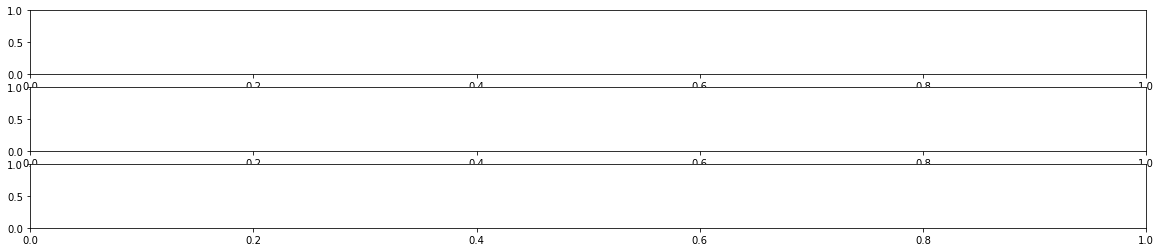

In [214]:
fig, axes = plt.subplots(3, 1, figsize=(20, 4))

# axes[0].plot([when(datum) for datum in monkey_specific_data[2]], [1] * len(monkey_specific_data[2]), marker='o')
# def get_colors(data):
#     colors = []
#     for datum in data:
events = [[when(datum) for datum in monkey_specific_data[2] if (key in datum.keys())] for key in ['stim0', 'stim1', 'resid']]
axes[0].eventplot([when(datum) for datum in monkey_specific_data[2] if not ('stim0' in datum.keys())])
axes[1].eventplot([when(datum) for datum in monkey_specific_data[2] if not ('stim1' in datum.keys())])
axes[2].eventplot([when(datum) for datum in monkey_specific_data[2] if not ('resid' in datum.keys())])

#TODO: Use data class to fix this!

### Plot progression of decision boundary over non-stimulated, stimulated and extended session

190


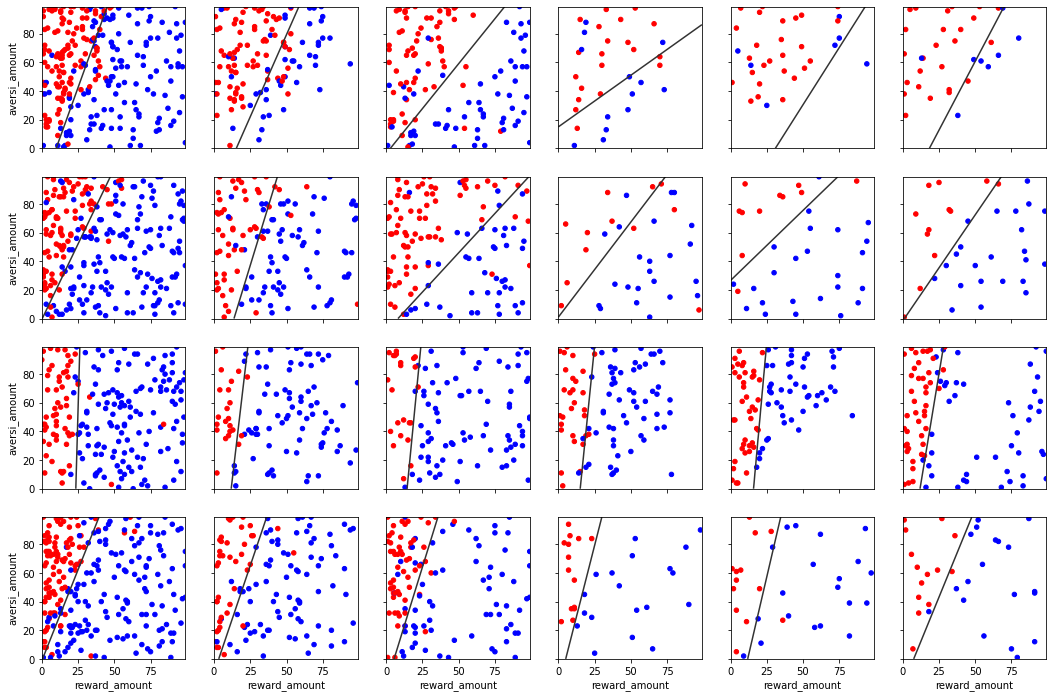

In [71]:
num_blocks_stim1 = 2
num_blocks_resid = 3
num_rows = 4
num_cols = 1 + num_blocks_stim1 + num_blocks_resid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 3, num_rows * 3))

clf = linear_model.LogisticRegression()

def chunks(df, n):
    """Yield successive n-sized chunks from df."""
    for i in range(0, len(df), n):
        yield df.iloc[i:i + n]

def plot_all(X, y, i, j):
    ax = axes[i, j]

    clf.fit(X, y)

    xx, yy = np.mgrid[0:100:1, 0:100:1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    X.plot.scatter('reward_amount', 'aversi_amount', c=y, colormap='bwr_r', ax=ax, sharex=True, sharey=True, colorbar=False)

for i in range(num_rows):

    stage = 'stim0'
    X = data[i][stage][['reward_amount', 'aversi_amount']]
    y = data[i][stage]['appro1_avoid0']
    plot_all(X, y, i, 0)

    stage = 'stim1'
    num_chunks = len(data[i][stage]) // num_blocks_stim1
    X = chunks(data[i][stage][['reward_amount', 'aversi_amount']], num_chunks)
    y = chunks(data[i][stage]['appro1_avoid0'], num_chunks)
    for j in range(1, num_blocks_stim1 + 1):
        plot_all(next(X), next(y), i, j)

    stage = 'resid'
    num_chunks = len(data[i][stage]) // num_blocks_resid
    X = chunks(data[i][stage][['reward_amount', 'aversi_amount']], num_chunks)
    y = chunks(data[i][stage]['appro1_avoid0'], num_chunks)
    for j in range(num_blocks_stim1+1, num_blocks_stim1 + num_blocks_resid + 1):
        plot_all(next(X), next(y), i, j)



### Differentiating between positive and negative stimulation

In [80]:
clf0 = linear_model.LogisticRegression()
clf1 = linear_model.LogisticRegression()

for i in range(len(data)):
    X_stim0 = data[i]['stim0'][['reward_amount', 'aversi_amount']]
    y_stim0 = data[i]['stim0']['appro1_avoid0']

    X_stim1 = data[i]['stim1'][['reward_amount', 'aversi_amount']]
    y_stim1 = data[i]['stim1']['appro1_avoid0']

    clf0.fit(X_stim0, y_stim0)
    clf1.fit(X_stim1, y_stim1)
    ap_prob_stim0 = clf0.predict_proba([[50, 50]])[0][1]
    ap_prob_stim1 = clf1.predict_proba([[50, 50]])[0][1]
    data[i]['metadata']['stim_increases_avoidance'] = True if (ap_prob_stim0 > ap_prob_stim1) else False

### Plot no stimulation, negative stimulation and positive stimulation

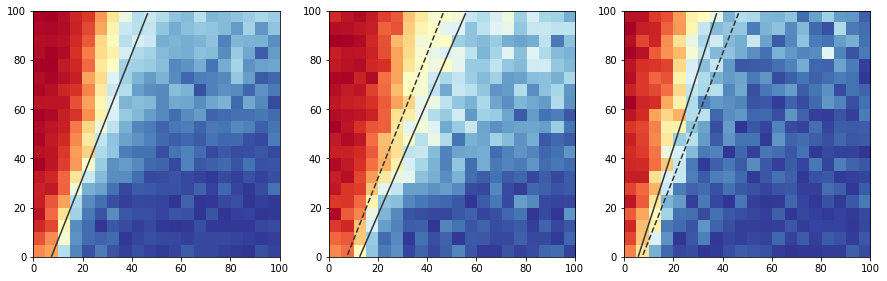

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

clf = linear_model.LogisticRegression()

def plot_heatmap(x, y, w, i, non_stim_probs=None):
    ax = axes[i]
    H, xedges, yedges = np.histogram2d(x, y, bins=20, weights=w)
    H2, _, _ = np.histogram2d(x,y, bins=20)
    H2 += 1
    H += 1
    extent = [0,100, 0, 100]
    ax.imshow(np.flipud((H/H2).T), extent=extent,interpolation='nearest', cmap='RdYlBu_r')
    # ax.colorbar()

    clf.fit(pd.concat((x, y), axis=1), w)

    xx, yy = np.mgrid[0:100:1, 0:100:1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    if i == 0:
        non_stim_probs = probs
    else:
        ax.contour(xx, yy, non_stim_probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linestyles='dashed')

    ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    return non_stim_probs

stage = 'stim0'
x, y, w = [], [], []
for i in range(len(data)):
    X = data[i][stage][['reward_amount', 'aversi_amount']]
    x += [X['reward_amount']]
    y += [X['aversi_amount']]
    w += [1 - data[i][stage]['appro1_avoid0']]
x = pd.concat(x)
y = pd.concat(y)
w = pd.concat(w)
nsp = plot_heatmap(x, y, w, 0)

stage = 'stim1'
x, y, w = [], [], []
for i in range(len(data)):
    if data[i]['metadata']['stim_increases_avoidance']:
        X = data[i][stage][['reward_amount', 'aversi_amount']]
        x += [X['reward_amount']]
        y += [X['aversi_amount']]
        w += [1 - data[i][stage]['appro1_avoid0']]
x = pd.concat(x)
y = pd.concat(y)
w = pd.concat(w)
plot_heatmap(x, y, w, 1, nsp)

x, y, w = [], [], []
for i in range(len(data)):
    if not data[i]['metadata']['stim_increases_avoidance']:
        X = data[i][stage][['reward_amount', 'aversi_amount']]
        x += [X['reward_amount']]
        y += [X['aversi_amount']]
        w += [1 - data[i][stage]['appro1_avoid0']]
x = pd.concat(x)
y = pd.concat(y)
w = pd.concat(w)
_ = plot_heatmap(x, y, w, 2, nsp)



### Looking at repetitive behavior

#### Autocorrelation

/Users/julianstastny/miniconda3/envs/mastersthesis/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


array([ 1.        , -0.02969926,  0.04948702,  0.05085449,  0.02310152,
        0.05298511,  0.06239621,  0.04284414,  0.02143784,  0.03208972,
        0.02718944,  0.01627501,  0.03289697,  0.0259428 ,  0.01104412,
        0.02013222,  0.02403947, -0.00203154,  0.02339565, -0.00486705,
        0.01947042])

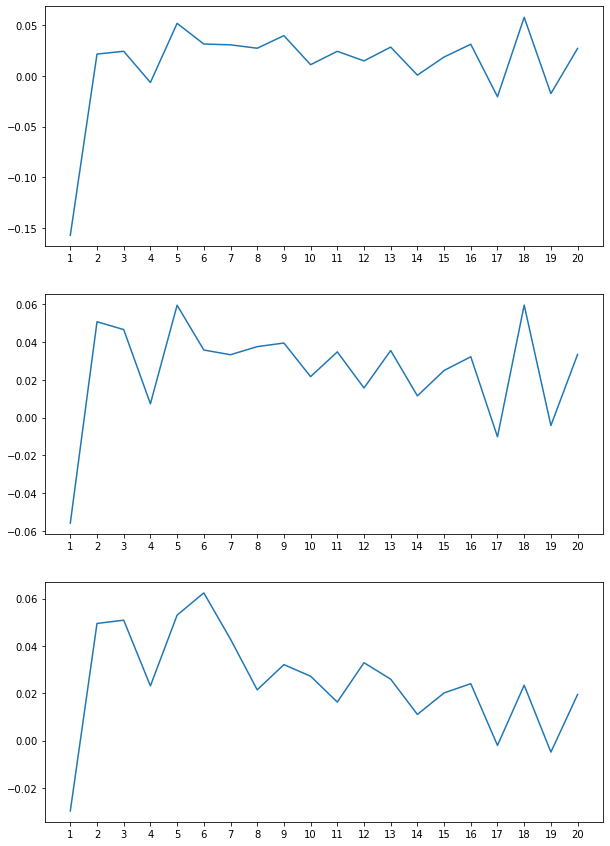

In [146]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

def plot_autocorrelation(stage, ax, stim_increases_avoidance=None, nlags=20, baseline_ac=None):
    w = []
    for i in range(len(data)):
        ac = [] 
        if stim_increases_avoidance is None:
            c = data[i][stage]['appro1_avoid0']
            ac = sm.tsa.acf(c, nlags=nlags, fft=True)
        elif stim_increases_avoidance:
            if data[i]['metadata']['stim_increases_avoidance']:
                c = data[i][stage]['appro1_avoid0']
                ac = sm.tsa.acf(c, nlags=nlags, fft=True)
        else:
            if not data[i]['metadata']['stim_increases_avoidance']:
                c = data[i][stage]['appro1_avoid0']
                ac = sm.tsa.acf(c, nlags=nlags,  fft=True)
        if len(ac) == (nlags+1):
            w += [ac]
    w = sum(w) / len(w)
    if baseline_ac is not None:
        w -= baseline_ac
    ax.set_xticks(np.arange(1, nlags+1), minor=False)
    ax.plot(np.arange(1, nlags+1), w[1:])

    return w

# bac = plot_autocorrelation('stim0', axes[0])
# plot_autocorrelation('stim1', axes[1], True, baseline_ac=bac)
# plot_autocorrelation('stim1', axes[2], False, baseline_ac=bac)
# plot_autocorrelation('resid', axes[3], True, baseline_ac=bac)
# _ = plot_autocorrelation('resid', axes[4], False, baseline_ac=bac)

bac = plot_autocorrelation('stim0', axes[0])
plot_autocorrelation('stim1', axes[1], baseline_ac=None)
plot_autocorrelation('resid', axes[2], baseline_ac=None)


### Plotting the decisions

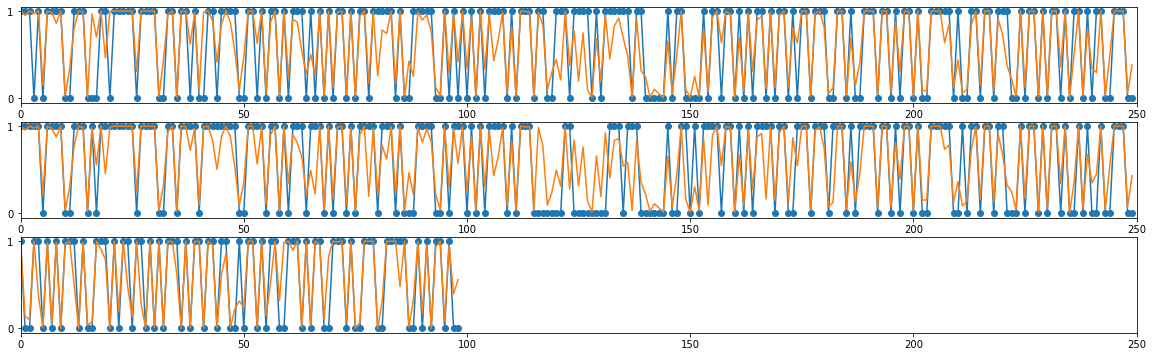

In [169]:

clf = linear_model.LogisticRegression()

j = 3
fig, axes = plt.subplots(3, 1, figsize=(20, 6))
for i, stage in enumerate(['stim0', 'stim1', 'resid']):
    X = data[j][stage][['reward_amount', 'aversi_amount']]
    y = data[j][stage]['appro1_avoid0']
    clf.fit(X, y)
    probs = clf.predict_proba(X)[:,1]
    axes[i].plot(y, marker='o')
    axes[i].plot(probs)
    axes[i].set_xlim(0, 250)
    axes[i].set_yticks([0, 1])